# Домашнее задание №2. Multi-class SVM.

Нужно реализовать несколько алгоритмов SVM с помощью numpy/scipy библиотек. Каждую из реализаций сравнить с соответсвующей sklearn реализацией SVM алгоритма. 

### Задание №1 (15 баллов)

Реализовать класс **LinearPrimalSVM** - метод решения **много-классового линейного метода опорных векторов в стандартной задаче  оптимизации с квадратичной регуляризацией**. Для обучения много-классового алгоритма воспользоваться схемой **one-vs-rest**.  Реализовать методы init, fit, predict c возможностью конфигурации параметра регуляризации. Остальные функции реализовать на ваше усмотрение. 

Для оптимизации функции ошибки воспользоваться методом **стохастического градиентного спуска**.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors

from scipy import optimize
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

%matplotlib inline

In [11]:
class LinearPrimalSVM:
    def __init__(self, n, m, regularization_type = "l2", lambd=1, learning_rate = 0.005,  max_iter=500):
        self.regularization_type = regularization_type
        self.lambd = lambd # параметр регуляризации
        self.learning_rate = learning_rate # шаг обучения
        self.max_iter =  max_iter # количество итераций
        self.w = np.random.uniform(-0., 0., size=(n, m)) 
    

    def objective_grad(self, x, w, y):
        # производная hinge loss дает ноль, если Margin хороший, иначе проивзодная его дает -(x * y), если не учитвать регуляризацию
        grad = np.zeros((x.shape[0]))
        Margin = y * np.dot(w, x)
        if Margin < 1:
            grad -= x * y
        if self.regularization_type == 'l2':
            grad += 2 * self.lambd * w
        return grad

    def fit(self, x_train, y_train, x_test, y_test, num_of_class):
        """функция обучения модели"""
        for step in range(self.max_iter):
            for i in range(x_train.shape[0]):
                Margin = y_train[i] * np.dot(self.w[num_of_class], x_train[i])
                self.w[num_of_class] -= self.learning_rate * self.objective_grad(x_train[i], self.w[num_of_class], y_train[i]) / x_train.shape[0]
            
            for i in range(x_test.shape[0]):
                Margin = y_test[i] * np.dot(self.w[num_of_class], x_test[i])
            
    def one_vs_rest(self, x_train, y_train, x_test, y_test):
        """нужно текущий класс обозначить за 1, все остальные за -1"""
        num_of_class = y_train.shape[1]
        results = []
        for current_class in range(num_of_class):
            curr_y_train = 2 * (y_train.T)[current_class] - 1
            curr_y_test = 2 * (y_test.T)[current_class] - 1
            results.append(self.fit(x_train, curr_y_train, x_test, curr_y_test, current_class))
        return results
    
    def predict(self, x):
        num_of_class = self.w.shape[0]
        pred = np.zeros((x.shape[0], num_of_class))
        for i in range(x.shape[0]):
            for c in range(num_of_class):
                pred[i][c] = np.sign(np.dot(self.w[c], x[i]))
        pred = (pred + 1) / 2
        return pred
    
    def score(self, prediction, y_true):
        pred = np.argmax(prediction, axis=1)
        accuracy = np.mean(pred == y_true)
        return accuracy * 100
    
    def weights(self):
        return self.w

Оцените ваш алгоритм на тестовом сплите многоклассовом датасете классификации по выбранной метрике качества. Датасеты для классификации можно взять например [**отсюда**](https://archive.ics.uci.edu/ml/datasets.php?format=&task=cla&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table) или сгенерировать самому. Сравните ваш алгоритм с sklearn имплементацией со следующими парарметрами:

[*_sklearn.linear_model.SGDClassifier(loss='hinge', penalty='l2', fit_intercept=True)_*](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)

Остальные параметры алгоритма на ваше усмотрение. 

Отличие в качестве не должно составлять более **1-2%** в пользу sklearn имплементации. Ваш алгоритм может работать лучше. 

#### Генерация данных

Будем генерировать данные с помощью make_classification.
Таким образом мы получили массив X координты объектов, а Y массив принадлежности классу.

X: (1100, 2) 
Y: (1100,)


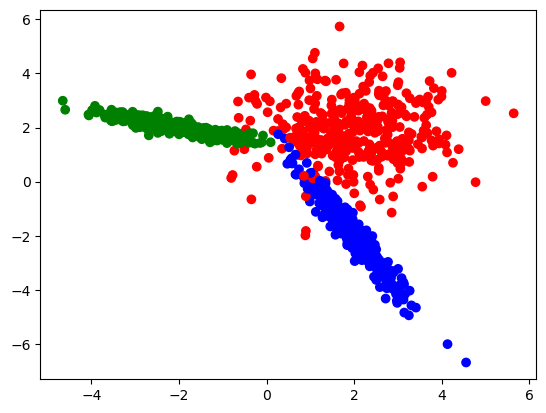

In [12]:
data = make_classification(n_samples=1100, n_features=2, n_informative=2, n_redundant=0, 
                        n_classes=3, n_clusters_per_class=1,  flip_y=0, class_sep=2, random_state=2)

X = data[0]
Y = data[1]
print(f"X: {X.shape} \nY: {Y.shape}")

# визуализация данных
color = {0:'blue', 1:'red', 2:'green'}
plt.scatter(X[:,0], X[:,1], c=[color[y] for y in Y])
plt.show()

Также нужно учесть смещение(bias), разделить данные на обучающую и тестовую выборки, а также выполнить one-hot кодирование.

In [13]:
# разделим
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)


# учтем смещение
x_train_b = np.concatenate((np.ones((x_train.shape[0], 1)), x_train), axis=1)
x_test_b = np.concatenate((np.ones((x_test.shape[0], 1)), x_test), axis=1)

# one-hot кодирование
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train_o= one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test_o = one_hot_encoder.fit_transform(y_test.reshape(-1, 1))

#### Работа с моделью

In [20]:
print(x_train.shape, y_train.shape)
print(type(y_train))
print(type(x_train))
sk_model = SGDClassifier(loss='hinge', penalty='l2', fit_intercept=True, random_state=0, max_iter=500, learning_rate='constant', eta0=0.005)
sk_model.fit(x_train, y_train)
sk_model_acc = sk_model.score(x_test, y_test) * 100
print(sk_model.coef_.shape)
print(sk_model.coef_)

my_model = LinearPrimalSVM(y_train_o.shape[1], x_train_b.shape[1], regularization_type='l2', lambd=0.0001, learning_rate=0.005, max_iter=500)
data = my_model.one_vs_rest(x_train_b, y_train_o, x_test_b, y_test_o)
prediction = my_model.predict(x_test_b)
accuracy_score = my_model.score(prediction, y_test)


print('sklearn model accuracy: ', round(sk_model_acc, 2))
print('My model accuracy: ', round(accuracy_score, 2))
print('delta:', round(abs(sk_model_acc - accuracy_score),2))

weights = my_model.weights()
weights

(770, 2) (770,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(3, 2)
[[-0.31967909 -1.27162665]
 [ 1.31746858  1.26024735]
 [-1.55225279 -0.21665949]]
sklearn model accuracy:  98.18
My model accuracy:  97.88
delta: 0.3


array([[-0.05245425, -0.00603527, -0.82722128],
       [-0.97789931,  0.56272161,  0.56111704],
       [-0.18147389, -0.86748038,  0.00546234]])

### Задание № 2 (10 баллов)

Визуализируйте построенные разделяющие прямые на вашем мультиклассовом датасете. Для визуализации можно пользоваться любыми библиотеками визуализации.

Вспомогательные функции для визуализации:

In [15]:
def plot_line(ax, x_range, w, label, color='grey', linestyle='-'):
    """График разделяющей прямой с помощью вектора весов w"""
    yy = -(w[1] / w[2]) * x_range - w[0] / w[2]
    ax.plot(x_range, yy, color=color, label=label, linestyle=linestyle)
    
def plot_svm(X, y, support=None, w=None, intercept=0., label='Data', separatorLabel='Separator', 
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """График SVM оптимальной разделяющей прямой c отображением опорных векторов support
    вектора весов w и смещения intercept"""
    if ax is None:
        fig, ax = plt.subplots(1)
    
    im = ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, alpha=0.5, label=label)
    if support is not None:
        ax.scatter(support[:,0], support[:,1], label='Support', s=80, facecolors='none', 
                   edgecolors='y', color='y')
        print("Количество опорных векторов = %d" % (len(support)))
    if w is not None:
        xx = np.array(bound[0])
        plot_line(ax, xx, w, intercept, separatorLabel)
        # Plot margin
        if support is not None:
            signed_dist = np.matmul(support, w)
            margin = np.max(signed_dist) - np.min(signed_dist) * np.sqrt(np.dot(w, w))
            support_max_neg = support[np.argmin(signed_dist)]
            plot_line(ax, xx, w, support_max_neg, 'Margin -', linestyle='-.', alpha=0.8)
            support_max_pos = support[np.argmax(signed_dist)]
            plot_line(ax, xx, w, support_max_pos, 'Margin +', linestyle='--', alpha=0.8)
            ax.set_title('Margin = %.3f' % (margin))
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    cb = plt.colorbar(im, ax=ax)
    loc = np.arange(-1,1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels(['-1','1'])

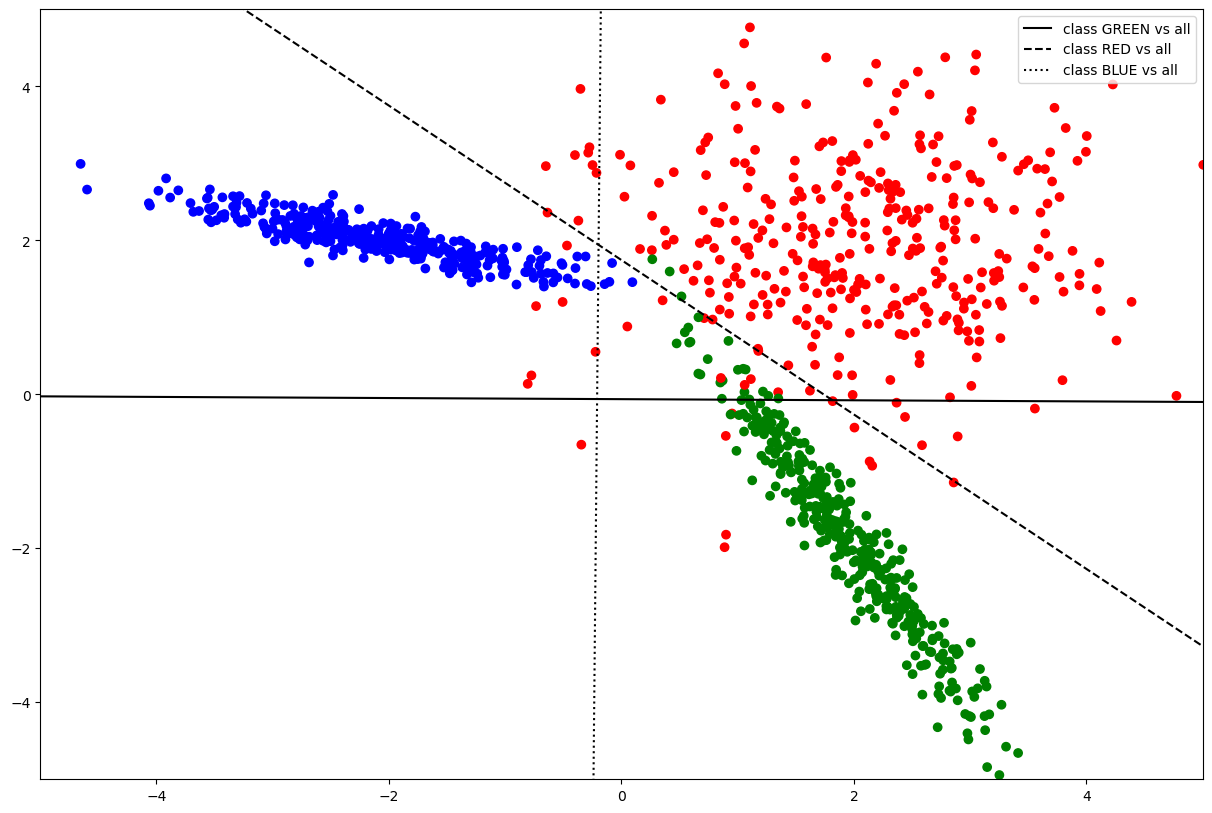

In [16]:
color = {0:'green', 1:'red', 2:'blue'}
fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(X[:,0], X[:,1], c=[color[y] for y in Y])
plot_line(ax, np.linspace(-5,5,100), weights[0], 'class GREEN vs all', color='black', linestyle='-')
plot_line(ax, np.linspace(-5,5,100), weights[1], 'class RED vs all', color='black', linestyle='--')
plot_line(ax, np.linspace(-5,5,100), weights[2], 'class BLUE vs all', color='black', linestyle=':')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
plt.legend()
plt.show()

Постройте график зависимости качества вашего алгоритма от параметра регуляризации на тестовом сплите. 

In [17]:
lambdas = [1e-10, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.05, 0.07, 0.1, 0.5, 0.6, 0.7, 0.8, 1, 10, 50, 100]
accuracy = []
for lambd in lambdas:
    my_model = LinearPrimalSVM(y_train_o.shape[1], x_train_b.shape[1], regularization_type='l2', lambd=lambd, learning_rate=0.005, max_iter=500)
    my_model.one_vs_rest(x_train_b, y_train_o, x_test_b, y_test_o)
    prediction = my_model.predict(x_test_b)
    accuracy.append(my_model.score(prediction, y_test))

KeyboardInterrupt: 

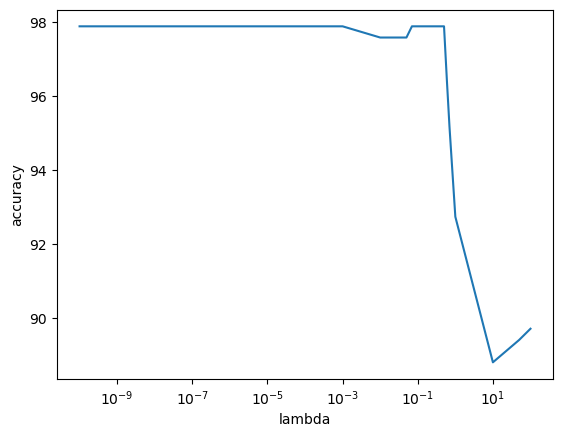

In [ ]:
plt.xscale('log')
plt.xlabel('lambda')
plt.ylabel('accuracy')

plt.plot(lambdas, accuracy)
plt.show()

### Задание №3 (10 баллов)

Реализовать **NonlinearDualSVM** - метод решения **много-классового нелинейного метода опорных векторов двойственной задаче  оптимизации с квадратичной регуляризацией с поддежкой любого нелинейного ядра**. Алгоритм решения SVM через двойственную задачу можно взять из ноутбука, который мы рассматривали в классе - вам нужно поддержать многоклассовое решение задачи и поддержку ядра для решений в нелинейном случае. 

Для обучения много-классового алгоритма воспользоваться схемой **one-vs-one**. В качестве нелинейного ядра можно взять любое нелинейное [отсюда](https://scikit-learn.org/stable/modules/svm.html#svm-kernels).

Возьмем данные из sklearn

In [ ]:
from sklearn.datasets import load_iris
data = load_iris()
X = data.data[:,[2, 3]]
Y = data.target

x_train, x_test, y_train, y_test = train_test_split(x_g, y_g, test_size=0.25, random_state=0)

**Подсказка**

Получить получить ядерную матрицу Грамма можно так:

```python 
# X shape is (N, dim)
# y_hat shape is (N, 1)

def kernel(x1, x2):
    return np.dot(x1, x2)

kernalized_X = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2: kernel(x1, x2), 1, X), 1, X)  
gram_matrix_Xy = kernalized_X * np.matmul(y_hat, y_hat.T) 
```

Оцените ваш алгоритм на тестовом сплите многоклассовом датасете классификации по выбранной метрике качества. Датасеты для классификации можно взять например [**отсюда**](https://archive.ics.uci.edu/ml/datasets.php?format=&task=cla&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table) или сгенерировать самому. Сравните ваш алгоритм с sklearn имплементацией со следующими параметрами:

[*_class sklearn.svm.SVC(kernel='poly/rbf/sigmoid')_*](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

Остальные параметры алгоритма на ваше усмотрение либо при необходимости для выбранного ядра. 

Ваш алгоритмом должен быть не хуже sklearn имплементации алгоритма (допустима разница **5%** в пользу sklearn). Ваш алгоритм может работать лучше. 

In [ ]:
sk_svc_model = SVC(kernel='sigmoid', random_state=0)
sk_svc_model.fit(x_train, y_train)
sk_svc_acc = sk_svc_model.score(x_test, y_test) * 100
print('sklearn model accuracy: ', round(sk_svc_acc, 2))

sklearn model accuracy:  94.0
